# Have the world become less peaceful?

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [1]:
# %pip install matplotlib-venn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


# Read and clean data

Import your data, either through an API or manually, and load it. 

## Caldara & Iacoviello (2022) Geopolitical Risk Index (GPR)

In [76]:
filename = 'GPR_quarter.xlsx'
gpr = pd.read_excel(filename, index_col=0, parse_dates=True)

gpr_new = dataproject.gpr_clean(gpr)

gpr_new

In [77]:
gpr_new.head(5)

AttributeError: 'gpr_clean' object has no attribute 'head'

In [2]:
# Loading the quarterly data for Geopolitical Risk Index (GPR)
filename = 'GPR_quarter.xlsx'
gpr = pd.read_excel(filename, index_col=0, parse_dates=True)

# Selecting the columns with the country specific hisotrical GPR index
gpr = gpr[[col for col in gpr.columns if col.startswith('GPRHC_')]]
gpr.head(5)

# Melt the DataFrame to long format
gpr_long = gpr.reset_index().melt(id_vars='Date', var_name='Country', value_name='GPRH')
gpr_long.set_index('Date', inplace=True)
gpr_long.head(10)

,Country,GPRH
Date,,
1900-01-01,GPRHC_ARG,0.017573
1900-04-01,GPRHC_ARG,0.000000
1900-07-01,GPRHC_ARG,0.026942
1900-10-01,GPRHC_ARG,0.017830
1901-01-01,GPRHC_ARG,0.004865
1901-04-01,GPRHC_ARG,0.009636
1901-07-01,GPRHC_ARG,0.014735
1901-10-01,GPRHC_ARG,0.122224
1902-01-01,GPRHC_ARG,0.026908


In [3]:
filename = 'country_lookup.xlsx'
country_lookup = pd.read_excel(filename)

gpr_long = gpr_long.reset_index().merge(country_lookup, on='Country', how='left').set_index(['Date', 'Country_name'])
gpr_long.reset_index(inplace=True)
gpr_long.drop(columns='Country', inplace=True)
gpr_long.head(10)

,Date,Country_name,GPRH
0,1900-01-01,Argentina,0.017573
1,1900-04-01,Argentina,0.000000
2,1900-07-01,Argentina,0.026942
3,1900-10-01,Argentina,0.017830
4,1901-01-01,Argentina,0.004865
5,1901-04-01,Argentina,0.009636
6,1901-07-01,Argentina,0.014735
7,1901-10-01,Argentina,0.122224
8,1902-01-01,Argentina,0.026908
9,1902-04-01,Argentina,0.009149


In [4]:
def standardize_gpr(df, country_col, gpr_col):
    df[gpr_col] = df.groupby(country_col)[gpr_col].transform(lambda x: (x - x.mean()) / x.std())
    return df

gpr_long = standardize_gpr(gpr_long, 'Country_name', 'GPRH')

## Direction of Trade Statistics (DOTS) from IMF

In [5]:
filename = 'dots_imf.xlsx'
dots_raw = pd.read_excel(filename)

In [6]:
dots_imf = dots_raw.copy()

In [7]:
# Fill out missing values with 0 as per documentation
dots_imf = dots_imf.fillna(0)

In [8]:
dots_imf['Trade'] = dots_imf['Export'] + dots_imf['Import']

dots_imf['tot_trade'] = dots_imf.groupby(['Country_Name', 'Date'])['Trade'].transform('sum')
dots_imf['trade_share'] = dots_imf['Trade'] / dots_imf['tot_trade']
dots_imf['check'] = dots_imf.groupby(['Country_Name', 'Date'])['trade_share'].transform('sum')
dots_imf['Date'] = pd.to_datetime(dots_imf['Date']).dt.to_period('Q').dt.start_time
dots_imf = dots_imf.rename(columns={'Country_Name': 'imf_name'})
dots_imf = dots_imf.rename(columns={'Counterpart_Country_Name': 'imf_name_counterpart'})
dots_imf.head(5)

,imf_name,Country_Code,imf_name_counterpart,Counterpart_Country_Code,Date,Export,Import,Trade,tot_trade,trade_share,check
0,United Kingdom,112,United States,111,1960-01-01,281500000.0,338500000.0,620000000.0,4.063600e+09,0.152574,1.0
1,United Kingdom,112,United States,111,1960-04-01,258600000.0,386600000.0,645200000.0,4.110800e+09,0.156952,1.0
2,United Kingdom,112,United States,111,1960-07-01,197900000.0,399600000.0,597500000.0,3.890000e+09,0.153599,1.0
3,United Kingdom,112,United States,111,1960-10-01,222900000.0,464600000.0,687500000.0,4.199100e+09,0.163726,1.0
4,United Kingdom,112,United States,111,1961-01-01,187200000.0,370800000.0,558000000.0,4.141100e+09,0.134747,1.0


In [9]:
filename = 'imf_name_lookup.xlsx'
imf_lookup = pd.read_excel(filename)
filename = 'imf_name_cp_lookup.xlsx'
imf_lookup_cp = pd.read_excel(filename)
dots_imf = dots_imf.reset_index().merge(imf_lookup, on='imf_name', how='left')
dots_imf = dots_imf.reset_index().merge(imf_lookup_cp, on='imf_name_counterpart', how='left')

In [10]:
dots_imf = dots_imf.rename(columns={'Country_name_x': 'country'})
dots_imf = dots_imf.rename(columns={'Country_name_y': 'counterpart'})
# print(dots_imf[dots_imf['imf_name'] == 'Belgium-Luxembourg'])

In [11]:
dots_imf = dots_imf[['Date','country', 'counterpart', 'trade_share']]
dots_imf = dots_imf.rename(columns={'country': 'Country_name', 'counterpart': 'Counterpart_name'})
dots_imf.head(5)

,Date,Country_name,Counterpart_name,trade_share
0,1960-01-01,United Kingdom,United States,0.152574
1,1960-04-01,United Kingdom,United States,0.156952
2,1960-07-01,United Kingdom,United States,0.153599
3,1960-10-01,United Kingdom,United States,0.163726
4,1961-01-01,United Kingdom,United States,0.134747


In [12]:
dots_imf.set_index(['Date', 'Country_name'], inplace=True)

In [13]:
dots_imf = dots_imf.sort_values(['Country_name', 'Date'])
dots_imf.head(5)

Counterpart_name  trade_share
Date       Country_name                              
1960-01-01 Argentina       United States     0.200482
           Argentina      United Kingdom     0.172904
           Argentina             Belgium     0.026921
           Argentina             Denmark     0.003064
           Argentina              France     0.048588

## Merging GPR and DOTS

In [14]:
# dots_imf = dots_imf.reset_index().rename(columns={'country': 'Country_name'})
merged_df = dots_imf.reset_index().merge(gpr_long, on=['Country_name', 'Date'], how='left')

In [15]:
merged_df = merged_df.rename(columns={'Country_name': 'name', 'Counterpart_name': 'Country_name'})
merged_df.head(5)

,Date,name,Country_name,trade_share,GPRH
0,1960-01-01,Argentina,United States,0.200482,0.193814
1,1960-01-01,Argentina,United Kingdom,0.172904,0.193814
2,1960-01-01,Argentina,Belgium,0.026921,0.193814
3,1960-01-01,Argentina,Denmark,0.003064,0.193814
4,1960-01-01,Argentina,France,0.048588,0.193814


In [16]:
merged_df_2 = merged_df.reset_index().merge(gpr_long, on=['Country_name', 'Date'], how='left')
merged_df_2.head(5)

,index,Date,name,Country_name,trade_share,GPRH_x,GPRH_y
0,0,1960-01-01,Argentina,United States,0.200482,0.193814,-0.325053
1,1,1960-01-01,Argentina,United Kingdom,0.172904,0.193814,-0.205214
2,2,1960-01-01,Argentina,Belgium,0.026921,0.193814,-0.415437
3,3,1960-01-01,Argentina,Denmark,0.003064,0.193814,-0.433675
4,4,1960-01-01,Argentina,France,0.048588,0.193814,0.077589


In [17]:
merged_df_2['product'] = merged_df_2['trade_share'] * merged_df_2['GPRH_y']
merged_df_2['sumproduct'] = merged_df_2.groupby(['Date', 'name'])['product'].transform('sum')

In [18]:
merged_df_2['GPRH_trade_weight'] = merged_df_2['sumproduct'] + merged_df_2['GPRH_x']
merged_df_2.head(5)

,index,Date,name,Country_name,trade_share,GPRH_x,GPRH_y,product,sumproduct,GPRH_trade_weight
0,0,1960-01-01,Argentina,United States,0.200482,0.193814,-0.325053,-0.065167,-0.291108,-0.097294
1,1,1960-01-01,Argentina,United Kingdom,0.172904,0.193814,-0.205214,-0.035482,-0.291108,-0.097294
2,2,1960-01-01,Argentina,Belgium,0.026921,0.193814,-0.415437,-0.011184,-0.291108,-0.097294
3,3,1960-01-01,Argentina,Denmark,0.003064,0.193814,-0.433675,-0.001329,-0.291108,-0.097294
4,4,1960-01-01,Argentina,France,0.048588,0.193814,0.077589,0.003770,-0.291108,-0.097294


In [19]:
merged_df_2_no_dub = merged_df_2.drop_duplicates(subset=['Date', 'name', 'GPRH_trade_weight'])
merged_df_2_no_dub.head(5)

,index,Date,name,Country_name,trade_share,GPRH_x,GPRH_y,product,sumproduct,GPRH_trade_weight
0,0,1960-01-01,Argentina,United States,0.200482,0.193814,-0.325053,-0.065167,-0.291108,-0.097294
33,33,1960-04-01,Argentina,United States,0.183906,0.568831,-0.107283,-0.019730,-0.107673,0.461158
66,66,1960-07-01,Argentina,United States,0.181598,0.491626,-0.209149,-0.037981,-0.002283,0.489343
98,98,1960-10-01,Argentina,United States,0.203185,0.276994,-0.176344,-0.035830,-0.134393,0.142600
132,132,1961-01-01,Argentina,United States,0.193917,-0.266736,-0.207954,-0.040326,-0.182932,-0.449667


In [20]:
gpr_trade = merged_df_2_no_dub[['Date','name', 'GPRH_trade_weight']]
gpr_trade.set_index(['Date', 'name'], inplace=True)
gpr_trade.head(5)

,,GPRH_trade_weight
Date,name,
1960-01-01,Argentina,-0.097294
1960-04-01,Argentina,0.461158
1960-07-01,Argentina,0.489343
1960-10-01,Argentina,0.142600
1961-01-01,Argentina,-0.449667


In [21]:
gpr_trade.reset_index(inplace=True)
gpr_trade.head(5)

,Date,name,GPRH_trade_weight
0,1960-01-01,Argentina,-0.097294
1,1960-04-01,Argentina,0.461158
2,1960-07-01,Argentina,0.489343
3,1960-10-01,Argentina,0.142600
4,1961-01-01,Argentina,-0.449667


In [22]:
gpr_long.head(5)

,Date,Country_name,GPRH
0,1900-01-01,Argentina,-0.416765
1,1900-04-01,Argentina,-0.577234
2,1900-07-01,Argentina,-0.331201
3,1900-10-01,Argentina,-0.414413
4,1901-01-01,Argentina,-0.532810


In [64]:
filename = 'IdealpointestimatesAll_Sep2023.csv'
df = pd.read_csv(filename, delimiter=';')

pivot_df = df.pivot_table(index='session', columns='Countryname', values='IdealPointAll')
pivot_df.columns.name = None

In [65]:
pivot_df['ideal_left'] = pivot_df[pivot_df < 0].mean(axis=1)
pivot_df['ideal_right'] = pivot_df[pivot_df > 0].mean(axis=1)
pivot_df.index = pd.date_range(start='01-01-1946', periods=len(pivot_df), freq='AS')
long_df = pivot_df.reset_index()
long_df = pivot_df.reset_index().melt(id_vars='index', var_name='Countryname', value_name='IdealPointAll')
long_df.head(5)

,index,Countryname,IdealPointAll
0,1946-01-01,Afghanistan,1.191005
1,1947-01-01,Afghanistan,0.239827
2,1948-01-01,Afghanistan,-0.064428
3,1949-01-01,Afghanistan,-0.419353
4,1950-01-01,Afghanistan,-0.605796


In [66]:
long_df = long_df.rename(columns={'Countryname': 'Country_name', 'index': 'Date'})
long_df.head(5)

,Date,Country_name,IdealPointAll
0,1946-01-01,Afghanistan,1.191005
1,1947-01-01,Afghanistan,0.239827
2,1948-01-01,Afghanistan,-0.064428
3,1949-01-01,Afghanistan,-0.419353
4,1950-01-01,Afghanistan,-0.605796


In [67]:
# Set 'session' and 'Countryname' as multi-index in both dataframes
long_df.set_index('Date', inplace=True)
# gpr_long.set_index('Date', inplace=True)

In [68]:
long_df_q = long_df.groupby('Country_name').resample('Q').ffill()

In [69]:
long_df_q.drop(columns='Country_name', inplace=True)
long_df_q.head(5)

IdealPointAll
Country_name Date                     
Afghanistan  1946-03-31       1.191005
             1946-06-30       1.191005
             1946-09-30       1.191005
             1946-12-31       1.191005
             1947-03-31       0.239827

In [70]:
# Convert 'Date' to Period with quarterly frequency, then convert back to timestamps at the start of the quarter
long_df_q.reset_index(inplace=True)
long_df_q['Date'] = long_df_q['Date'].dt.to_period('Q').dt.to_timestamp()

# Set 'Date' and 'Country_name' back as the index
long_df_q.set_index(['Date', 'Country_name'], inplace=True)

In [71]:
merged_df = gpr_long.reset_index().merge(long_df_q, on=['Country_name', 'Date'], how='left')
merged_df = merged_df[merged_df['Date'].dt.year >= 1946]
merged_df.head(5)

,Date,Country_name,GPRH,IdealPointAll
184,1946-01-01,Argentina,0.429051,1.860128
185,1946-04-01,Argentina,0.514888,1.860128
186,1946-07-01,Argentina,0.505425,1.860128
187,1946-10-01,Argentina,0.539356,1.860128
188,1947-01-01,Argentina,0.272223,2.214596


In [74]:
# drop NaA values
merged_df.dropna(inplace=True)
merged_df.set_index(['Date', 'Country_name'], inplace=True)

In [81]:
# Calculate the average of 'IdealPointAll' by 'Country_name'
average_ideal_point = merged_df.groupby(level='Country_name')['IdealPointAll'].mean()

# Create a new column that assigns 1 if the average of 'IdealPointAll' is positive and 0 otherwise
merged_df['NewColumn'] = merged_df.index.get_level_values('Country_name').map(lambda x: 1 if average_ideal_point[x] > 0 else 0)

In [83]:
average_ideal_point = merged_df.groupby([merged_df.index.get_level_values('Date'), 'NewColumn'])['GPRH'].mean()
average_ideal_point.head(5)

Date        NewColumn
1946-01-01  0            0.290006
            1            0.254046
1946-04-01  0            0.306110
            1            0.208162
1946-07-01  0            0.330395
Name: GPRH, dtype: float64

In [82]:
merged_df.head(50)

,,GPRH,IdealPointAll,NewColumn
Date,Country_name,,,
1946-01-01,Argentina,0.429051,1.860128,1
1946-04-01,Argentina,0.514888,1.860128,1
1946-07-01,Argentina,0.505425,1.860128,1
1946-10-01,Argentina,0.539356,1.860128,1
1947-01-01,Argentina,0.272223,2.214596,1
1947-04-01,Argentina,0.157388,2.214596,1
1947-07-01,Argentina,1.359836,2.214596,1
1947-10-01,Argentina,0.060924,2.214596,1
1948-01-01,Argentina,-0.065262,0.676745,1


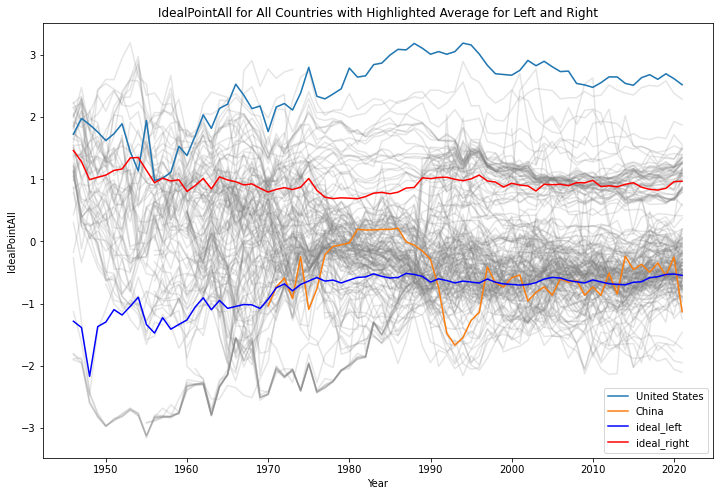

In [123]:
# Plot the underlying 'IdealPointAll' lines in grey
plt.figure(figsize=(12,8))
for column in pivot_df.columns:
    if column not in ['ideal_left', 'ideal_right']:
        plt.plot(pivot_df.index, pivot_df[column], color='grey', alpha=0.2)

# Plot the 'ideal_left' and 'ideal_right' lines in different colors
plt.plot(pivot_df.index, pivot_df['United States'], label='United States')
plt.plot(pivot_df.index, pivot_df['China'], label='China')
plt.plot(pivot_df.index, pivot_df['ideal_left'], color='blue', label='ideal_left')
plt.plot(pivot_df.index, pivot_df['ideal_right'], color='red', label='ideal_right')

plt.xlabel('Year')
plt.ylabel('IdealPointAll')
plt.title('IdealPointAll for All Countries with Highlighted Average for Left and Right')
plt.legend()
plt.show()

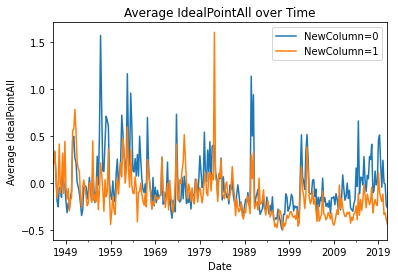

In [85]:
# Create separate line plots for each value of 'NewColumn'
for new_column_value in average_ideal_point.index.get_level_values('NewColumn').unique():
    subset = average_ideal_point.xs(new_column_value, level='NewColumn')
    subset.plot(kind='line', label=f'NewColumn={new_column_value}')

plt.title('Average IdealPointAll over Time')
plt.xlabel('Date')
plt.ylabel('Average IdealPointAll')
plt.legend()
plt.show()

## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

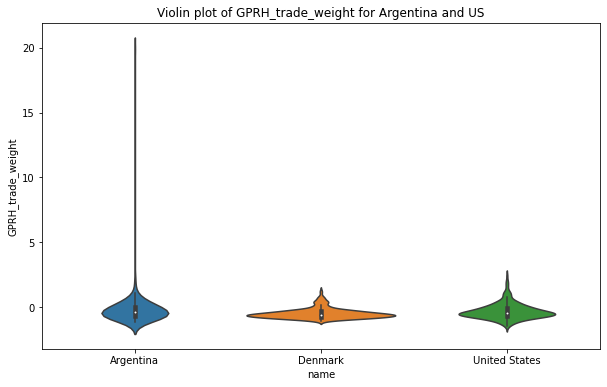

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data for Argentina and US
gpr_trade_filtered = gpr_trade[gpr_trade['name'].isin(['Argentina', 'United States', 'Denmark'])]

# Create violin plot
plt.figure(figsize=(10,6))
sns.violinplot(x='name', y='GPRH_trade_weight', data=gpr_trade_filtered)
plt.title('Violin plot of GPRH_trade_weight for Argentina and US')
plt.show()

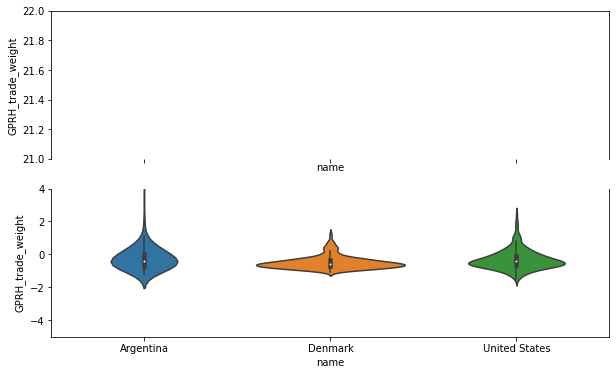

In [58]:
# Filter data for Argentina, US, and Denmark
gpr_trade_filtered = gpr_trade[gpr_trade['name'].isin(['Argentina', 'United States', 'Denmark'])]

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,6))

# Set the y-axis limits for the top and bottom plots
ax1.set_ylim(21, 22)  # top plot
ax2.set_ylim(-5, 4)  # bottom plot

# Hide the spines between the two plots
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Create the violin plots
sns.violinplot(x='name', y='GPRH_trade_weight', data=gpr_trade_filtered, ax=ax1)
sns.violinplot(x='name', y='GPRH_trade_weight', data=gpr_trade_filtered, ax=ax2)

# Add a title
# plt.title('Violin plot of GPRH_trade_weight for Argentina, US, and Denmark')

# Show the plot
plt.show()

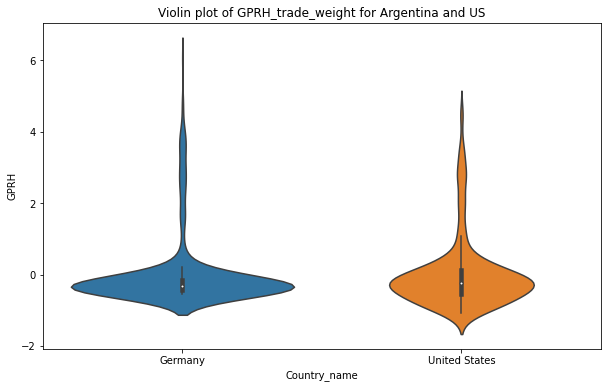

In [61]:
# Filter data for Argentina and US
gpr_long_filtered = gpr_long[gpr_long['Country_name'].isin(['Germany', 'United States'])]

# Create violin plot
plt.figure(figsize=(10,6))
sns.violinplot(x='Country_name', y='GPRH', data=gpr_long_filtered)
plt.title('Violin plot of GPRH_trade_weight for Argentina and US')
plt.show()

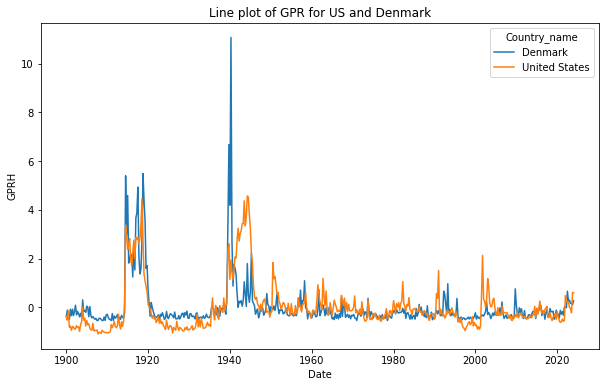

In [66]:
# Filter data for US and Denmark
gpr_long_filtered = gpr_long[gpr_long['Country_name'].isin(['United States', 'Denmark'])]

# Create line plot
plt.figure(figsize=(10,6))
sns.lineplot(x='Date', y='GPRH', hue='Country_name', data=gpr_long_filtered)
plt.title('Line plot of GPR for US and Denmark')
plt.show()

**Interactive plot** :

In [2]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


interactive(children=(Output(),), _dom_classes=('widget-interact',))

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

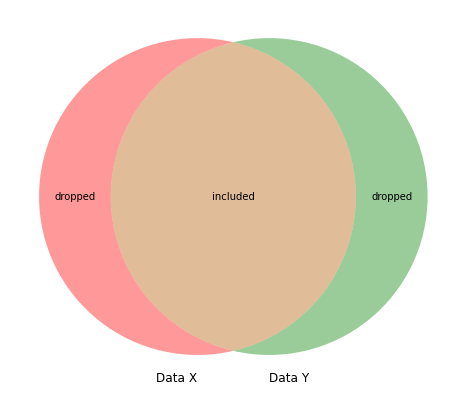

In [3]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.